# Assignment 5: Stochastic Signals and Power Spectrum Estimation

In [81]:
# Initiation
import numpy as np
from numpy import pi, sin, cos, exp
import matplotlib.pyplot as plt
from scipy.signal import lfilter

plt.rcParams.update({
    "text.usetex": True,               # Use LaTeX for all text
    "font.family": "serif",            # Use a serif font
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: load additional LaTeX packages
})

In [82]:
N=2048

mu=0
sigma=1

## Part 1: Generation of a random sequence x[n] of a known PSD
We pass a random normally distributed signal $r_w[n]\sim N(\mu=0,\sigma^2)$ through a digital filter H(z) where:
$$
H(z)=\frac{1}{(1-0.9z^{-1})(1-0.9jz^{-1})(1+0.9jz^{-1})}
$$
to get $x[n]$. Thus ensuring that the Power spectral density of $x[n]$ is $|H(e^{j2\pi f})|^2 \cdot \sigma^2$

In [83]:
# Generation of x[n] and the filter
r=np.random.normal(mu, sigma,N)
b=[1]
a=[1,-0.9,0.81,-0.729]
x=lfilter(b,a,r)

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1247247/729356807.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Power Spectral Density of x[n], $|H(e^{j2 \pi f})|^2 \sigma^2$')


Text(0.5, 0, 'Normalised frequency $f$')

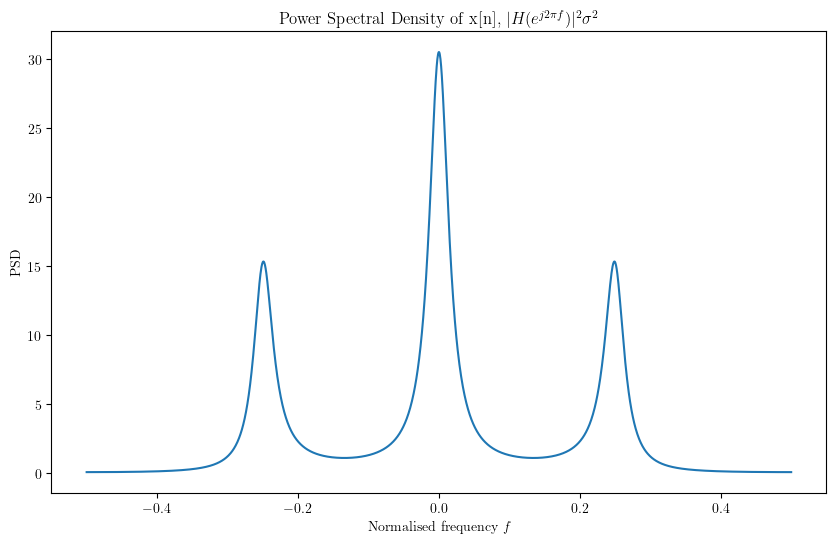

In [84]:
# Graph of PSD
f=np.linspace(-0.5, 0.5, N)
z=exp(-2j*pi*f)
H_f=np.polyval(b,z)/np.polyval(a,z)
plt.figure(figsize=(10,6))
plt.plot(f, abs(H_f*sigma)**2)
plt.title('Power Spectral Density of x[n], $|H(e^{j2 \pi f})|^2 \sigma^2$')
plt.ylabel('PSD')
plt.xlabel('Normalised frequency $f$')

## Part 2: The Welch Nonparametric method: Average modified periodogram

The PSD of a random sequence $x[n]$ is defined as:
$$
P_{xx}(f)=\lim_{N\rightarrow \infty} \frac{1}{2N+1} E\Big\{\Big|\sum_{n=-M}^{M} x[n] e^{-j2\pi fn}\Big|^2\Big\}
$$
and in the classical periodogram it is estimated as (after doing a reindex for $x[n]$ of length $N$):
$$
\hat{P}_{xx}(f)=\frac{1}{N}\Big|\sum_{n=0}^{M-1}x[n] e^{-j2\pi fn}\Big|^2
$$

(This is equivalent to using a naive estimator $E(\vec{x})=x_i$)

In [85]:
#Defining variables and chopping x[n] into L bits
L=8
D=4
M=int(np.ceil((N+(L-1)*D)/L))

X_div=np.zeros((L,M))
index=0
i=0
j=0
while(index<N):
    X_div[i][j]=x[index]
    index+=1
    j+=1
    if(j==M):
        j=0
        i+=1
        index-=D

In [86]:
# Defining the Hamming window and its energy 
w=np.zeros(M)
for i in range(M):
    w[i]=0.54-0.46*cos(2*pi*i/M)
U=1/M*np.dot(w,w)

In [87]:
P=np.zeros((L,N),dtype=np.complex128)
for i in range(L):
    for j in range(N):
        for k in range(M):
            P[i][j]+=X_div[i][k]*w[k]*(z[j]**k)
    P[i][j]=abs(np.abs(P[i][j])**2/(M*U))

Text(0, 0.5, 'PSD')

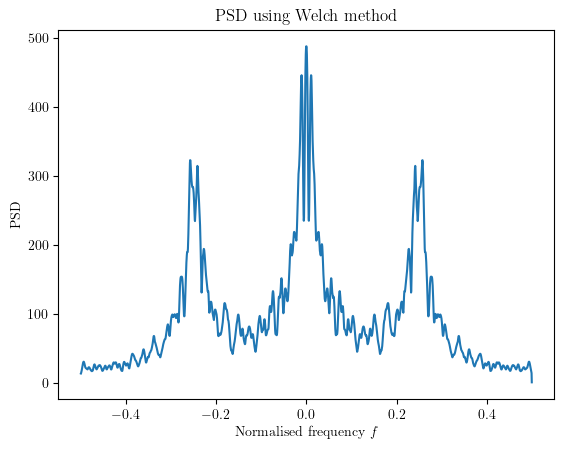

In [90]:
P_x=np.zeros(N)
for i in range(L):
    for j in range(N):
        P_x[j]+=abs(P[i][j])
plt.plot(f,P_x)
plt.title('PSD using Welch method')
plt.xlabel('Normalised frequency $f$')
plt.ylabel('PSD')

# Part 3: Parametric methods for Power Spectrum estimation: Yule-Walker AR Method
We can improve upon the naive estimator by exploiting some prior knowledge about the source of the data generation. If we know through what process the data was generated, we can then just find estimates for the parameters for the model itself. We would not need a windowing then. Thus, this can be particularly useful when the length of the signal $N$ is quite small.

The simplest model of this kind is an auto-regressive model.

A $p^{th}-$ order AR model has the transfer function:
$$
H(z)=\frac{1}{1+\sum_{k=1}^{p}a_{k}z^{-k}}
$$ 
And the sequence is assumed to be white noise passed through the system.
